In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
# from jupyterthemes import jtplot
# jtplot.style(theme='monokai', fscale=1.5)
np.random.seed(42)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Sparse linear regression and compressed sensing

We will now look into a different class of models, namely that of *generalized linear models* or GLMs. As before, we will implement AMP algorithms to perform estimation in these models, and try to obtain insights on the models by looking at AMP's state evolution.

Let's start by considering the following *sparse linear regression* problem. We use a Gaussian likelihood to impose the linear relation between the observations ${\bf y} \in \mathbb{R}^M$ and the latent variable ${\bf x}$, and a Bernoulli-Gaussian prior to enforce ${\bf x} \in \mathbb{R}^N$ to be *sparse*, i.e. for most of its components to be identically zero

$$\left\{
\begin{aligned}
&x_i \sim \rho \, \mathcal{N} (x; 0, 1) + (1 - \rho) \, \delta(x) \\
&y_\mu \sim \mathcal{N} \big(y_\mu; \sum_i F_{\mu i} x_i, \sigma^2\big)
\end{aligned}
\right.
$$

Using Bayes theorem we then obtain the following posterior on the latent variable ${\bf x}$

$$P({\bf x} | {\bf y}, F) \propto \prod_{\mu} \mathcal{N} \big(y_\mu; \sum_i F_{\mu i} x_i, \sigma^2\big) \, \prod_i P_0 (x_i)$$

As before we start by sampling from the generative model $P({\bf x}, {\bf y} | F)$. We assume that $F_{\mu i} \sim \mathcal{N} (0, 1/N)$. The important parameters are:

- the rows-to-columns ratio in $F$, which we denote by $\alpha = M/N$, and
- the fraction of nonzero elements in ${\bf x}$, $\rho$.

**Exercise 3**: compute ${\bf y}$ below, after the remaining variables have been already sampled.

In [3]:
# %load exo3.py
def sample_instance(size_x, frac_nonzeros, rows_to_columns, var_noise):
    """Samples F from P(F) and {x, y} from P(x, y | F)"""
    
    # Some pre-processing
    size_nonzeros = int(np.ceil(frac_nonzeros * size_x))
    size_y = int(np.ceil(rows_to_columns * size_x))
    
    # Sample x from P_0(x)
    x0 = np.zeros(size_x)
    nonzeros = np.random.choice(size_x, size_nonzeros, replace=False)
    x0[nonzeros] = np.random.randn(size_nonzeros)
    
    # Generate F and y = Fx + noise
    F = np.random.randn(size_y, size_x) / np.sqrt(size_x)
    noise = np.sqrt(var_noise) * np.random.randn(size_y)
    
    y = F.dot(x0) + noise

    return x0, F, y

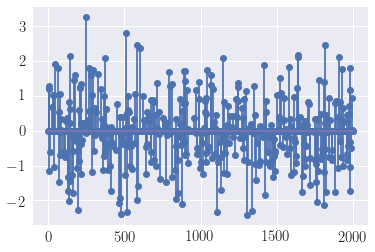

In [25]:
sns.set_context("notebook", font_scale=1.5)
x, F, y = sample_instance(2000, 0.2, 0.5, 1e-5)
plt.stem(x);

Note that many of the componentd of ${\bf x}$ are zero, as expected.

## AMP for sparse linear regression

The AMP iteration for the model above reads (see [1, 2])

$$
\begin{aligned}
&V_\mu^t = \sum_i F_{\mu i}^2 c_i^t, &\qquad
&\omega_\mu^t = \sum_i F_{\mu i} a_i^t + V_\mu^t \frac{y - \omega_\mu^{t-1}}{V_\mu^{t-1} + \sigma^2}, \\
&A_i^t = \sum_\mu \frac{F_{\mu i}^2}{V_\mu^t + \sigma^2}, &\qquad
&B_i^t = A_i^t a_i^t + \sum_\mu F_{\mu i} \frac{y_\mu - \omega_\mu^{t-1}}{V_\mu^{t-1} + \sigma^2}, \\
&c_i^{t + 1} = f_c (A_i^t, B_i^t), &\qquad
&a_i^{t + 1} = f_a (A_i^t, B_i^t).
\end{aligned}
$$

where $f_{a, c}$ are given by the first and second derivatives of $\log Z (A, B) = \log \int dx \, P_0 (x) \, e^{-\frac12 A x^2 + Bx}$ wrt $B$. Note that the only part of the iteration that depends on the prior $P_0 (x)$ is $f_{a, c}$.

Let's first implement the iteration, then $f_{a, c}$ for the Bernoulli-Gaussian prior.

In [5]:
def iterate_amp(F, y, var_noise, frac_nonzeros,
                x0=None, max_iter=100, tol=1e-7, verbose=1):
    """Iterates AMP to solve y = Fx, w/ x Bernoulli-Gaussian"""
    
    # Some pre-processing
    size_y, size_x = F.shape
    sqrF = F * F
    
    # Initialize variables
    A = np.ones(size_x)
    B = np.zeros(size_x)
    a = np.zeros(size_x)
    c = np.ones(size_x)
    v = np.ones(size_y)
    w = np.copy(y)
    
    mses = np.zeros(max_iter)
    for t in range(max_iter):
        # Store old v and compute new v and w
        v_old = np.copy(v)
        v = sqrF.dot(c)
        w = F.dot(a) - v * ((y - w) / (var_noise + v_old))
        
        # Iterate A and B and compute new mean and variance
        a_old = np.copy(a)
        A = sqrF.T.dot(1 / (var_noise + v))
        B = F.T.dot((y - w) / (var_noise + v)) + A * a
        a, c = prior(A, B, frac_nonzeros)
        
        # Compute metrics
        diff = np.mean(np.abs(a - a_old))
        mses[t] = np.mean((a - x0) ** 2) if x0 is not None else 0
        
        # Print iteration status on screen
        if verbose:
            print("t = %d, diff = %g; mse = %g" % (t, diff, mses[t]))
        
        # Check for convergence
        if diff < tol:
            break
            
    return mses[:t]

In order to implement $f_{a, c}$, we need to compute $\log Z (A, B)$ and its derivatives. This can be performed in closed-form for the Bernouli-Gaussian prior and is left as an exercise for the reader ;)

In [6]:
def prior(A, B, rho):
    """Compute f and f' for Bernoulli-Gaussian prior"""
    
    # let x = s * t, with s ~ Bernoulli(p) and t ~ N(0, 1); then m = E(t), v = Var(t), p = E(s)
    m = B / (1 + A)
    v = 1 / (1 + A)
    p = rho / (rho + (1 - rho) * np.sqrt(1 + A) * np.exp(-.5 * m ** 2 / v))
    
    # compute E(s * t) and Var(s * t) from E(t), Var(t) and E(s)
    a = p * m
    c = p * v + p * (1 - p) * m ** 2
    return a, c

Let's see if our implementation works. We'll test it with the data with generated before.

In [7]:
mses_amp = iterate_amp(F, y, var_noise=1e-5, frac_nonzeros=0.2, x0=x);

t = 0, diff = 0.0398033; mse = 0.172325
t = 1, diff = 0.144805; mse = 0.098441
t = 2, diff = 0.141992; mse = 0.0639177
t = 3, diff = 0.0991968; mse = 0.0407444
t = 4, diff = 0.0669662; mse = 0.0268848
t = 5, diff = 0.0454614; mse = 0.0178901
t = 6, diff = 0.0372369; mse = 0.0121785
t = 7, diff = 0.0278882; mse = 0.00876821
t = 8, diff = 0.0228935; mse = 0.00580281
t = 9, diff = 0.019284; mse = 0.00377963
t = 10, diff = 0.0170755; mse = 0.0022014
t = 11, diff = 0.0144038; mse = 0.00138264
t = 12, diff = 0.0120123; mse = 0.000803358
t = 13, diff = 0.00941466; mse = 0.000445088
t = 14, diff = 0.00756945; mse = 0.000248029
t = 15, diff = 0.0057566; mse = 0.000125473
t = 16, diff = 0.00406548; mse = 6.29563e-05
t = 17, diff = 0.0024762; mse = 3.46423e-05
t = 18, diff = 0.00139796; mse = 1.89512e-05
t = 19, diff = 0.000933051; mse = 1.18642e-05
t = 20, diff = 0.000637904; mse = 9.84183e-06
t = 21, diff = 0.000431823; mse = 8.83734e-06
t = 22, diff = 0.00031091; mse = 8.44828e-06
t = 23, diff

It seems to be converging (`diff` is going down), and it's also able to find an estimate which is very close to the planted solution (`mse` is going down).

It's not always true that one can recover the planted solution: as a matter of fact, this only happens if ${\bf x}$ is sparse enough (i.e. $\rho$ is small enough), or if we made enough measurements (i.e. $\alpha$ is large enough). We'll study the interplay between $\rho$ and $\alpha$ in what follows.

But first, let's implement the state evolution for the algorithm above.

## State evolution

The state evolution is given by the following iteration

$$
A^{t + 1} = \frac{\alpha}{V^t + \sigma^2}, \qquad
V^{t + 1} = \int dx \, P_0(x) \int Dz \, f_a (A^t, A^t x + \sqrt{A^t} z).
$$

Let's implement and test it.

**Exercise 4**: implement the computation of $A^{t + 1}$ below. Tip: $\alpha$ is called `rows_to_columns` in the code

In [8]:
# %load exo4.py
from scipy.integrate import quad

def iterate_se(frac_nonzeros, rows_to_columns, var_noise, max_iter=100, tol=1e-7, verbose=1):
    """Iterates state evolution associated to AMP implementation above"""
    
    # Define function to be integrated at each step
    f = lambda A: lambda z: np.exp(-z ** 2 / 2) / np.sqrt(2 * np.pi) * \
            ((1 - frac_nonzeros) * prior(A, np.sqrt(A) * z, frac_nonzeros)[1] + \
             frac_nonzeros * prior(A, np.sqrt(A * (1 + A)) * z, frac_nonzeros)[1])
    
    v = np.zeros(max_iter)
    v[0] = frac_nonzeros
    
    for t in range(max_iter - 1):
        A = rows_to_columns / (var_noise + v[t])
        v[t + 1] = quad(f(A), -10, 10)[0]
        
        diff = np.abs(v[t + 1] - v[t])
        if verbose:
            print("t = %d, diff = %g; v = %g" % (t, diff, v[t + 1]))
            
        if diff < tol:
            break
    
    return v[:t + 1]

In [9]:
mses_se = iterate_se(frac_nonzeros=0.2, rows_to_columns=0.5, var_noise=1e-5);

t = 0, diff = 0.0942057; v = 0.105794
t = 1, diff = 0.0377029; v = 0.0680914
t = 2, diff = 0.0211465; v = 0.0469449
t = 3, diff = 0.0137278; v = 0.0332171
t = 4, diff = 0.0096076; v = 0.0236095
t = 5, diff = 0.00698217; v = 0.0166274
t = 6, diff = 0.00514239; v = 0.011485
t = 7, diff = 0.00376954; v = 0.00771542
t = 8, diff = 0.00271023; v = 0.00500519
t = 9, diff = 0.00188795; v = 0.00311724
t = 10, diff = 0.00126128; v = 0.00185596
t = 11, diff = 0.000801748; v = 0.00105421
t = 12, diff = 0.000482362; v = 0.00057185
t = 13, diff = 0.000274055; v = 0.000297795
t = 14, diff = 0.000147184; v = 0.000150611
t = 15, diff = 7.50335e-05; v = 7.55775e-05
t = 16, diff = 3.65645e-05; v = 3.90129e-05
t = 17, diff = 1.71881e-05; v = 2.18248e-05
t = 18, diff = 7.87279e-06; v = 1.3952e-05
t = 19, diff = 3.5468e-06; v = 1.04052e-05
t = 20, diff = 1.58304e-06; v = 8.82216e-06
t = 21, diff = 7.03213e-07; v = 8.11895e-06
t = 22, diff = 3.11674e-07; v = 7.80727e-06
t = 23, diff = 1.37996e-07; v = 7.6692

(0, 30)

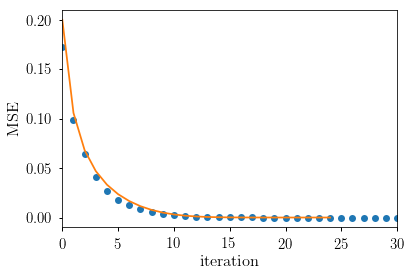

In [10]:
# Compare MSE obtained in AMP and state evolution, *at each iteration*
plt.plot(mses_amp, "o")
plt.plot(mses_se, "-")
plt.ylabel("MSE")
plt.xlabel("iteration")
plt.xlim([0, 30])

Note that here the state evolution is actually able to predict AMP performance *at each iteration*. In low-rank matrix factorization this wasn't possible, due to the existence of a trivial fixed-point which doesn't allows us to perform an uninformative initialization.

## The Donoho-Tanner transition

Sparse linear regression has been studied at least since the 90s; the LASSO estimator for instance, which proposes to find a sparse solution in a linear system by solving

$$
\hat{x} (y) = \operatorname*{arg\,min}_x \; \| y - Fx \|^2_2 + \lambda \| x \|_1
$$

has been introduced in 1996 by Tibshirani. In the 2000s however, a surge of interest has occurred in the field of signal processing, due to the realization that, with these techniques, a signal could be recovered using fewer-than-usual measurements, as long the signal is in an appropriate basis.

Donoho and Tanner [5] studied how many measurements are needed for a signal with a fraction $\rho$ of nonzero elements to be recovered using the LASSO estimator (and other similar approaches that employ $\ell_1$ regularization). This result can also be obtained using replica theory, see [3, 4]. We draw this curve below using the approach described in the Appendix B of [2].

Text(0,0.5,'rows to columns ratio $\\alpha$')

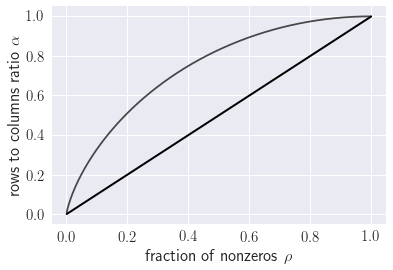

In [27]:
from scipy.special import erfc
from scipy.optimize import root

def find_dt_transition(rho, max_iter=250, tol=1e-11):
    """Fixed-point iteration to find Donoho-Tanner transition"""
    
    # $\lambda$ at each iteration is updated s.t. $f(\lambda) = 0$
    f = lambda alpha: lambda lamb: alpha * lamb - (1 - rho) * np.sqrt(2 / np.pi) * np.exp(-.5 * lamb ** 2)

    # Solve system of equations in $\lambda$ and $\alpha$ using fixed-point iteration
    alpha = 0.5
    for t in range(max_iter):
        alpha_old = alpha
        lamb = root(f(alpha), 1)["x"][0]
        alpha = rho + (1 - rho) * erfc(lamb / np.sqrt(2))
        
        if np.abs(alpha_old - alpha) < tol:
            break
        
    return alpha

# Run for many rhos and plot results
rhos = np.arange(0.001, 1.0, 0.001)
alphas = [find_dt_transition(rho) for rho in rhos]

plt.plot(rhos, rhos, "k-", lw=2)
plt.plot(rhos, alphas, "k-", alpha=0.7)
plt.xlabel(r"fraction of nonzeros $\rho$")
plt.ylabel(r"rows to columns ratio $\alpha$")

Let's understand the figure above. It tells us for which value of $\rho$ and $\alpha$ the $\ell_1$ approach works: for all values above the gray curve. One should also notice that below the solid black curve, it is actually impossible to solve the problem, as the linear system can't be solved even if only the nonzero elements are considered.

But what about the region between the solid and gray lines? Can any algorithm work in there? Also, how well does AMP in solving this problem?

Let's analyze the performance of AMP. We want to determine at what value of $\alpha$ AMP starts providing a "good" solution, i.e. a solution of small MSE, at a fixed value of $\rho$. That can be done by means of a binary search, using the results provided by the state evolution.

In [12]:
def find_spinodal(rho, tol=1e-3, threshold=1e-2, verbose=1):
    """Determines algorithmic transition by performing binary search"""
    
    # Returns True if solution has been found
    f = lambda x: (iterate_se(rho, x, 1e-10, verbose=0)[-1] < threshold)
    
    # Perform binary search
    alpha_l, alpha_r = rho, 1
    f_l, f_r = f(alpha_l), f(alpha_r)
    while alpha_r - alpha_l > tol:
        alpha_m = .5 * (alpha_l + alpha_r)
        f_m = f(alpha_m)
        if verbose:
            print("alpha = %g, found solution = %s" % (alpha_m, f_m))
        
        if f_m:
            alpha_r = alpha_m
        else:
            alpha_l = alpha_m
            
    return .5 * (alpha_l + alpha_r)

find_spinodal(0.2)

alpha = 0.6, found solution = True
alpha = 0.4, found solution = True
alpha = 0.3, found solution = False
alpha = 0.35, found solution = False
alpha = 0.375, found solution = True
alpha = 0.3625, found solution = True
alpha = 0.35625, found solution = False
alpha = 0.359375, found solution = True
alpha = 0.357813, found solution = False
alpha = 0.358594, found solution = False


0.358984375

In [32]:
# Run for many rhos and plot results
rhos_amp = np.linspace(0.01, 1, 34)
alphas_amp = np.zeros(len(rhos_amp))
for i, rho in enumerate(rhos_amp):
    alphas_amp[i] = find_spinodal(rho, tol=1e-3, verbose=False)
    print("rho = %g, alpha = %g" % (rho, alphas_amp[i]))

rho = 0.01, alpha = 0.0104834
rho = 0.04, alpha = 0.0985938
rho = 0.07, alpha = 0.156733
rho = 0.1, alpha = 0.209424
rho = 0.13, alpha = 0.257017
rho = 0.16, alpha = 0.302324
rho = 0.19, alpha = 0.345435
rho = 0.22, alpha = 0.385674
rho = 0.25, alpha = 0.424683
rho = 0.28, alpha = 0.461758
rho = 0.31, alpha = 0.497661
rho = 0.34, alpha = 0.532393
rho = 0.37, alpha = 0.565337
rho = 0.4, alpha = 0.597754
rho = 0.43, alpha = 0.628442
rho = 0.46, alpha = 0.658545
rho = 0.49, alpha = 0.686729
rho = 0.52, alpha = 0.714531
rho = 0.55, alpha = 0.742041
rho = 0.58, alpha = 0.767441
rho = 0.61, alpha = 0.792432
rho = 0.64, alpha = 0.816836
rho = 0.67, alpha = 0.839834
rho = 0.7, alpha = 0.861426
rho = 0.73, alpha = 0.882666
rho = 0.76, alpha = 0.902031
rho = 0.79, alpha = 0.92084
rho = 0.82, alpha = 0.938477
rho = 0.85, alpha = 0.954004
rho = 0.88, alpha = 0.968594
rho = 0.91, alpha = 0.980664
rho = 0.94, alpha = 0.990156
rho = 0.97, alpha = 0.997656
rho = 1, alpha = 1


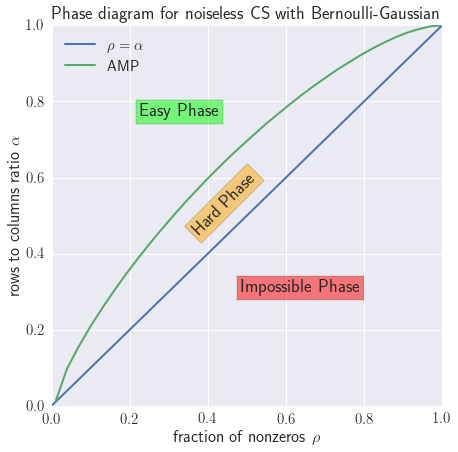

In [71]:
ax = plt.figure(figsize=(7,7))
plt.plot(rhos, rhos, lw=2, label=r'$\rho=\alpha$')
# plt.plot(rhos, alphas, label="DT")
plt.plot(rhos_amp, alphas_amp, lw=2, label="AMP")
plt.legend()
plt.xlabel(r"fraction of nonzeros $\rho$")
plt.ylabel(r"rows to columns ratio $\alpha$")
plt.title('Phase diagram for noiseless CS with Bernoulli-Gaussian')
plt.xlim((0,1))
plt.ylim((0,1))

ax.text(0.3, 0.7, 'Easy Phase', bbox=dict(facecolor=(0,1,0), alpha=0.5))
ax.text(0.4, 0.57, 'Hard Phase', rotation=45, bbox=dict(facecolor='orange', alpha=0.5))
ax.text(0.5, 0.35, 'Impossible Phase', bbox=dict(facecolor=(1,0,0), alpha=0.5))
plt.savefig('../Lecture Notes/CS_AMP_phase_diagram.pdf', bbox_inches='tight')

So that's it: for this problem, AMP seems to perform better than $\ell_1$-based approaches! 

Notice however that we have made a few assumptions: that $F_{\mu i} \sim \mathcal{N} (0, 1/N)$, and that the signal we try to reconstruct is actually sampled from $P_0 (x)$, which is Bernoulli-Gaussian with known parameters. If these assumptions are not met, AMP might be not as good, or, even worse -- it might not even converge!

A lot of effort has been made in the last few years, by our group and others, so as to made AMP more robust in dealing with real-world data. For recent developments see [6, 7].

## References

1. Zdeborová, Lenka, and Florent Krzakala. "Statistical physics of inference: Thresholds and algorithms." Advances in Physics 65.5 (2016): 453-552.

2. Krzakala, Florent, et al. "Probabilistic reconstruction in compressed sensing: algorithms, phase diagrams, and threshold achieving matrices." Journal of Statistical Mechanics: Theory and Experiment 2012.08 (2012): P08009.

3. Donoho, David L., Arian Maleki, and Andrea Montanari. "Message-passing algorithms for compressed sensing." Proceedings of the National Academy of Sciences 106.45 (2009): 18914-18919.

4. Kabashima, Yoshiyuki, Tadashi Wadayama, and Toshiyuki Tanaka. "A typical reconstruction limit for compressed sensing based on lp-norm minimization." Journal of Statistical Mechanics: Theory and Experiment 2009.09 (2009): L09003.

5. Donoho, David L., and Jared Tanner. "Sparse nonnegative solution of underdetermined linear equations by linear programming." Proceedings of the National Academy of Sciences of the United States of America 102.27 (2005): 9446-9451.

6. Manoel, Andre, et al. "Sparse estimation with the swept approximated message-passing algorithm." arXiv preprint arXiv:1406.4311 (2014).

7. Rangan, Sundeep, Philip Schniter, and Alyson K. Fletcher. "Vector approximate message passing." Information Theory (ISIT), 2017 IEEE International Symposium on. IEEE, 2017.